In [1]:
import sys
# sys.path.insert(0, '../pretty-print-confusion-matrix/')
from util import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve

import warnings
warnings.simplefilter(action='ignore', category=[FutureWarning])

In [2]:
rawtest = pd.read_csv('./data/test.csv')
datatrain = pd.read_csv('cl_train.csv')
datatest = pd.read_csv('cl_test.csv')

In [3]:
X = datatrain.drop(columns=['Survived'])
Y = datatrain['Survived']
Xt = datatest

In [4]:
X.shape, Xt.shape, Y.shape

((891, 29), (418, 29), (891,))

In [5]:
# X.head()

In [6]:
# Xt.head()

Sex_male      0.825112
Sex_female    0.820628
Mr            0.798206
Mrs           0.735426
Fare          0.677130
Miss          0.677130
Pclass        0.668161
Capt          0.663677
Don           0.650224
Embarked_C    0.645740
dtype: float64

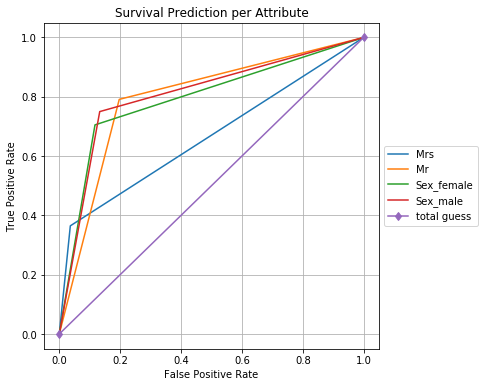

In [7]:
thres = 0.68
temp_acc = pd.Series()

for c in X.columns.tolist():
    tempX = np.array(X[c]).reshape(-1, 1)
    XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(tempX, Y)
    my_model = LogisticRegression(solver='liblinear').fit(XTRAIN, YTRAIN)
    model_prediction = my_model.predict(XTEST)
    acc = accuracy_score(YTEST, model_prediction)
    temp_acc[c] = acc
    if acc > thres:
        SY = my_model.predict_proba(XTEST)[:,1] # second column = probability
        SFPR, STPR, STHRESH = roc_curve(YTEST, SY)
        plt.plot(SFPR, STPR, label=c)
    
plt.plot([0,1],[0,1], label='total guess', marker='d')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Survival Prediction per Attribute")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.gcf().set_size_inches(6,6)

temp_acc.sort_values(ascending=False)[:10]

In [8]:
print("Worst predictors")
temp_acc.sort_values(ascending=False)[20:]

Worst predictors


Major         0.605381
Dona          0.600897
Dr            0.587444
Embarked_S    0.587444
Age           0.578475
Lady          0.569507
SibSp         0.569507
Parch         0.565022
Sir           0.556054
dtype: float64

In [9]:
def show_grid_results(grid_search):
    print('Best parameters:\n {} \n'.format( grid_search.best_params_ ))
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(mean_score, params)

In [10]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    # Best predictor
    {'multi_class': ['ovr'], 'penalty': ['none'], 'solver': ['newton-cg']},
    
#     { 'solver':['liblinear'] },
#     { 'solver':['newton-cg'], 'penalty':['l2', 'none'], 'multi_class':['ovr', 'multinomial', 'auto'] },
    
#     { 'solver':['lbfgs'], 'penalty':['l2', 'none'], 'multi_class':['ovr', 'multinomial', 'auto'] },
#     { 'solver':['saga'], 'penalty':['elasticnet'], 'l1_ratio':[1, 0.7], 'multi_class':['ovr', 'multinomial', 'auto'] }
#     { 'solver':['sag'], 'penalty':['l2'], 'max_iter':[100] }
]
model = LogisticRegression()
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='accuracy', return_train_score=True)
grid_search.fit(X, Y)
show_grid_results(grid_search)

Best parameters:
 {'multi_class': 'ovr', 'penalty': 'none', 'solver': 'newton-cg'} 

0.8237934904601572 {'multi_class': 'ovr', 'penalty': 'none', 'solver': 'newton-cg'}


In [11]:
best_model = grid_search.best_estimator_
best_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)


<img src='https://cdn-images-1.medium.com/max/1200/1*uR09zTlPgIj5PvMYJZScVg.png' style='width:400px;'>

In [40]:
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X, Y)
SY = best_model.predict_proba(XTEST)[:,1] # second column = probability
SFPR, STPR, STHRESH = roc_curve(YTEST, SY)
YP = best_model.predict(XTEST)
cm = confusion_matrix(YTEST, YP)
f1score = f1_score(YTEST, YP)

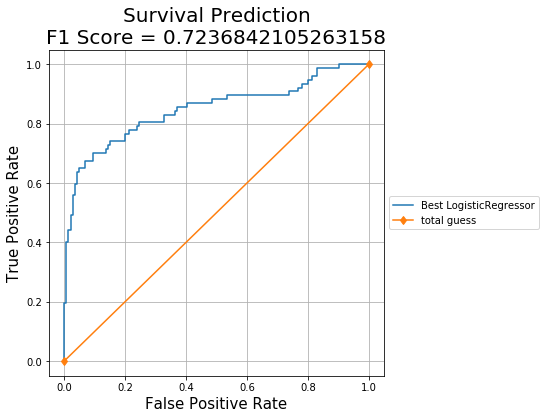

In [41]:
plt.plot(SFPR, STPR, label='Best LogisticRegressor')
plt.plot([0,1],[0,1], label='total guess', marker='d')
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("Survival Prediction\nF1 Score = "+str(f1score), fontsize=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.gcf().set_size_inches(6,6)

In [42]:
dfcm = pd.DataFrame(cm, columns=["Survived", "Not"]).set_index( pd.Index(['Survived', 'Not']) )
dfcm

,Survived,Not
Survived,126,20
Not,22,55


F1 SCORE:	 0.7236842105263158


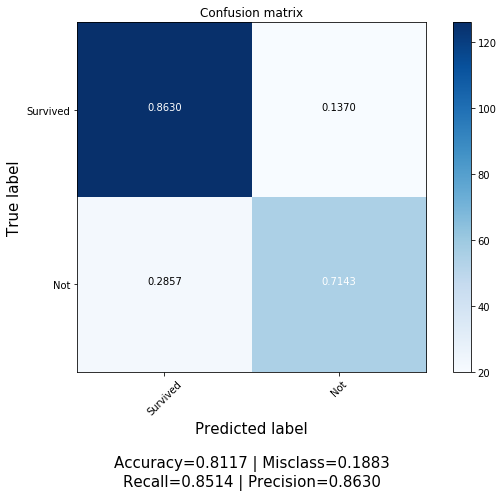

In [43]:
print('F1 SCORE:\t', f1score)
plot_confusion_matrix(cm, target_names=['Survived', 'Not'], normalize=True)

# Predict the test data

In [44]:
Yt = best_model.predict(Xt)

In [45]:
output = pd.concat([Xt['PassengerId'], pd.Series(Yt)], axis=1)
output.columns=['PassengerId', 'Survived']
output.shape

(418, 2)

In [46]:
output.tail()

,PassengerId,Survived
413,1305,0.0
414,1306,1.0
415,1307,0.0
416,1308,0.0
417,1309,1.0


In [47]:
import datetime
date = datetime.datetime.now()
_result_file = './results/result_'+date.strftime("%b-%d %H %M %S")+'.csv'
output.to_csv(_result_file, index=False)

# Submitting the gender_submission.csv file gives a 0.76555 score

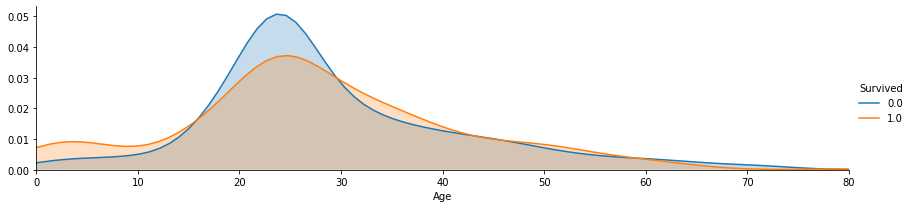

In [20]:
#plot distributions of age of passengers who survived or did not survive
a = sns.FacetGrid( datatrain, hue = 'Survived', aspect=4 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , datatrain['Age'].max()))
a.add_legend()